Импорт библиотек

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

Смотрим исходные данные

In [125]:
train = pd.read_excel("data/train.xlsx")
test = pd.read_excel("data/test.xlsx")

arr = [train, test]
names_df = ['train', 'test']

def analyze_data(data, name):
      print(f'Анализ данных для {name}:')
      print(data.describe())

def perenos_():
      print('\n******************************************************************\n')

for i, elem in enumerate(arr):
    analyze_data(elem, names_df[i])

Анализ данных для train:
                        dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668
Анализ данных для test:
                        dt  Цена на арматуру
count                   28         28.000000
mean   2022-12-08 12:00:00      44250.000000
min    2022-09-05 00:00:00      40000.000000
25%    2022-10-22 06:00:00      41925.000000
50%    2022-12-08 12:00:00      42900.000000
75%    2023-01-24 18:00:00      45625.000000
max    2023-03-13 00:00:00      55500.000000
std                    NaN       3645.951585


In [126]:
for i, elem in enumerate(arr):
     # Смотрим info
     print(f'Инфо {names_df[i]}')
     elem.info()

     # Смотрим кол-во строк + столбцов
     print(f"\n{names_df[i]} имеет: {elem.shape[0]} строк, {elem.shape[1]} столбца")

     # Смотрим колонки с разными типами данных
     numeric_columns = elem.select_dtypes(include=['int64', 'float64']).columns
     dt_columns = elem.select_dtypes(include=['datetime64']).columns

     # Выводим колонки     
     print(f"\nКол-во 'Числовых' колонок в {names_df[i]}: {len(numeric_columns)}")
     print(f"\nКол-во 'Дата-Тайм' колонок в {names_df[i]}: {len(numeric_columns)}")

     perenos_()

Инфо train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB

train имеет: 400 строк, 2 столбца

Кол-во 'Числовых' колонок в train: 1

Кол-во 'Дата-Тайм' колонок в train: 1

******************************************************************

Инфо test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes

test имеет: 28 строк, 2 столбца

Кол-во 

Смотрим пропущенные значения

In [127]:
def propuski(train_data, test_data):
    isxod_train = train_data.isnull().sum()
    isxod_test = test_data.isnull().sum()

    # Объединяем результаты в DataFrame
    combined_isxod = pd.concat([isxod_train, isxod_test], axis=1)
    combined_isxod.columns = ['Train', 'Test']

    # Выводим результат
    print(combined_isxod)

propuski(train, test)

                  Train  Test
dt                    0     0
Цена на арматуру      0     0


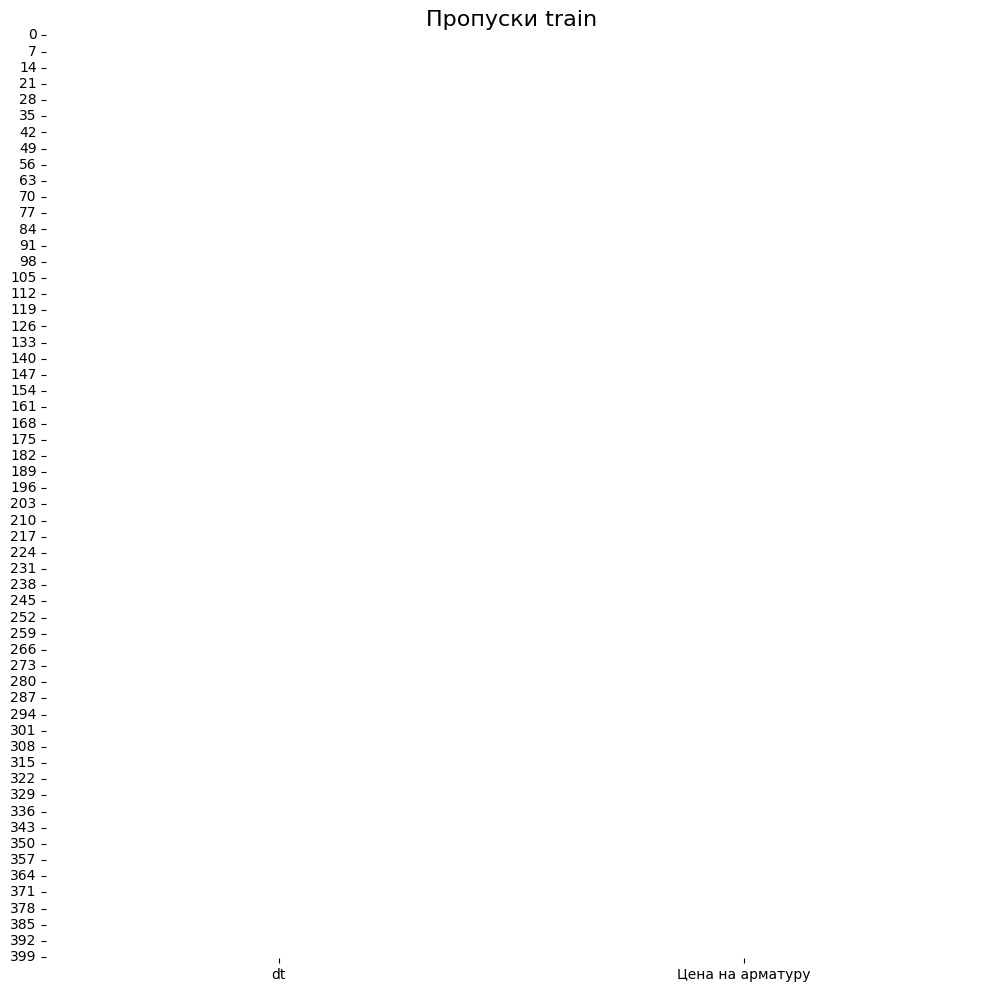

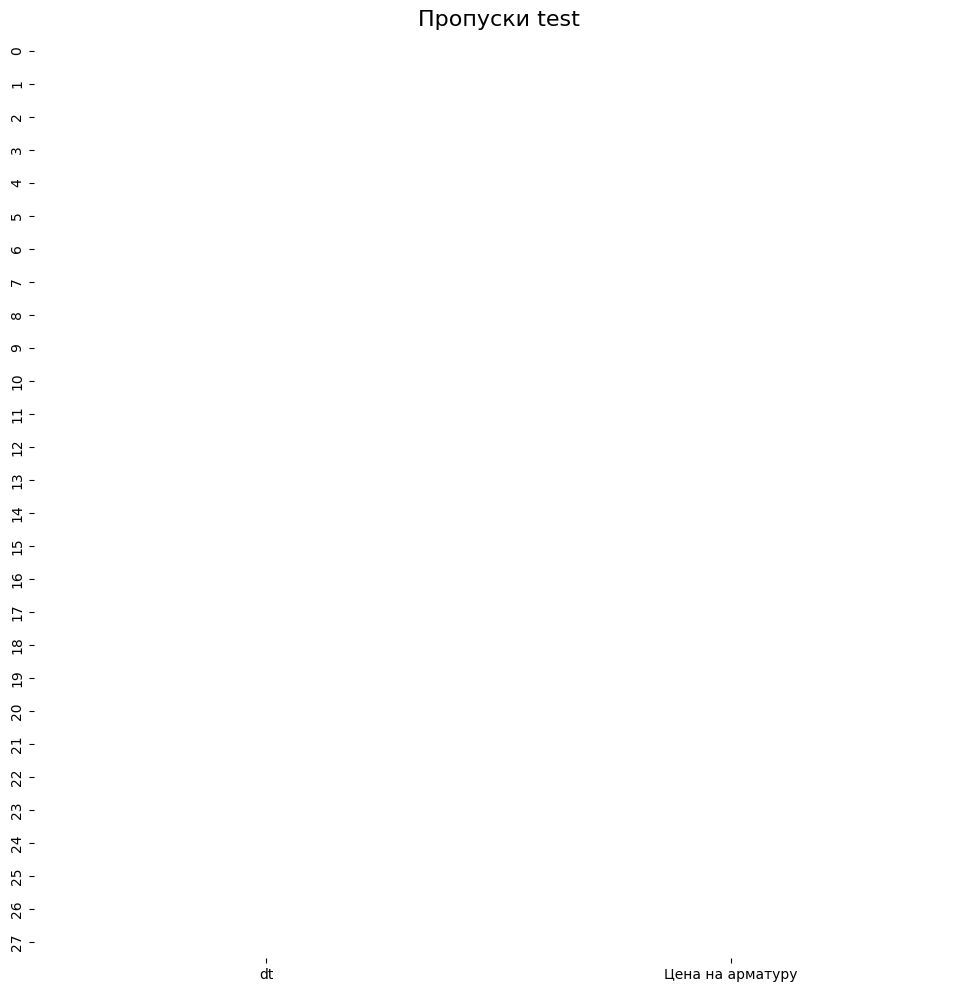

In [128]:
for i, elem in enumerate(arr): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {names_df[i]}", fontsize=16)
      plt.show()

In [129]:
train.head(3)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000


In [130]:
test.head(3)

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000


Обучение // модель CatBoost

In [131]:
# Временные признаки
train['year']=train['dt'].dt.year # год
train['month']=train['dt'].dt.month # месяц
train['weekday']=train['dt'].dt.weekday # день недели
# Эти признаки помогают модели учитывать сезонные и временные колебания

# Лаги
# Учитывается последние 6 недель
for lag in range(1, 7):
      train[f"lag_{lag}"] = train["Цена на арматуру"].shift(lag)
# позволяет модели учитывать предыдущие значения при прогнозировании текущего

# Разделение данных c помощью кросс-валидации (TimeSeriesSplit)
X = train.drop(columns=["dt", "Цена на арматуру"])
y = train["Цена на арматуру"]

TSSplit = TimeSeriesSplit(n_splits=5)

# Модель CatBoost
model = CatBoostRegressor(random_seed=42, verbose=0)  # verbose=0 отключает вывод информации во время обучения

# Подбор гиперпараметров
param_grid = {
    'iterations': [100], # Количество деревьев, которые модель будет строить
    'depth': [3, 6, 9], # Максимальная глубина дерева
    'learning_rate': [0.1, 0.2, 0.3], # Скорость обучения
    'l2_leaf_reg': [2, 4] # Контроль величины весов дерева (Регуляризация)
}

grid_search = GridSearchCV(model, param_grid, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

# Оценка модели
y_pred = grid_search.predict(X)
r2 = r2_score(y, y_pred)  # r2
mae = mean_absolute_error(y, y_pred) # mae

print(f"R2: {r2}")
print(f"MAE: {mae}")

R2: 0.986739673302802
MAE: 1084.9804935316433


In [132]:
# Временные признаки
test['year'] = test['dt'].dt.year
test['month'] = test['dt'].dt.month
test['weekday'] = test['dt'].dt.weekday

# Лаги (учитываются последние 6 недель)
for lag in range(1, 7):
    test[f"lag_{lag}"] = test["Цена на арматуру"].shift(lag)

X_test = test.drop(columns=["dt", "Цена на арматуру"])
y_test = test["Цена на арматуру"]

y_pred = grid_search.predict(X_test)

# Оценка модели
test_r2 = r2_score(y_test, y_pred)  # R²
test_mae = mean_absolute_error(y_test, y_pred)  # MAE

print(f"Test R2: {test_r2}")
print(f"Test MAE: {test_mae}")

Test R2: -1.0672650368359626e-05
Test MAE: 2101.103643221424


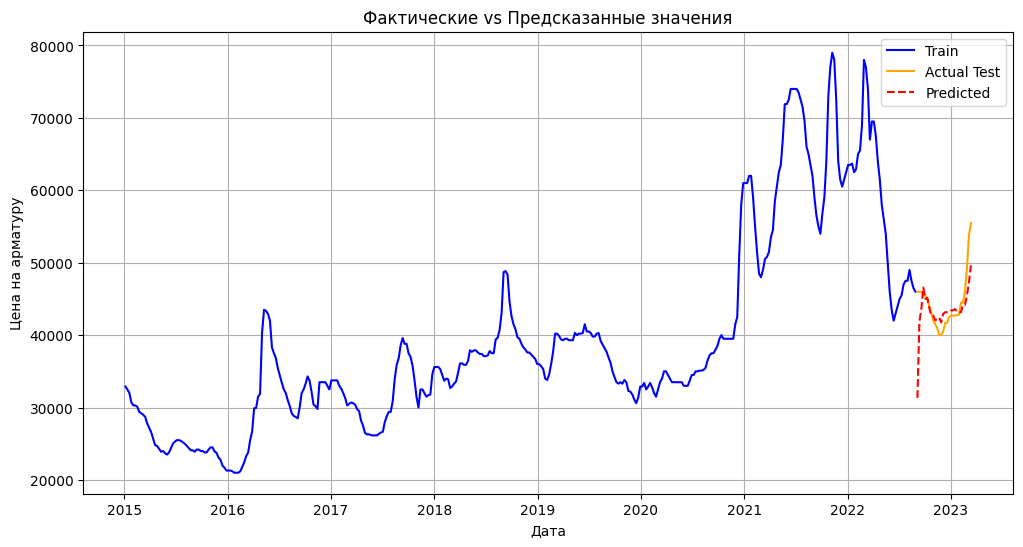

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue')  # фактические значения для обучения
plt.plot(test['dt'], y_test, label='Actual Test', color='orange')  # фактические значения для тестирования
plt.plot(test['dt'], y_pred, label='Predicted', color='red', linestyle='dashed')  # предсказанные значения
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения')
plt.legend()
plt.grid()
plt.show()